## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
FORCE_CPU = False
SEED = 2384

HIDDEN_SIZE = 16
TASK_TRAIN_SIZE = 100000
TASK_TEST_SIZE = 1000
TASK_LR = 0.01
TASK_EPOCHS = 10000
TASK_SCHEDULER_PATIENCE = 1000

SAVE_MODEL = False
LOAD_MODEL = True
MODEL_PATH = "saved_models/hierarchical-equality.pt"

In [46]:
import random
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import pandas as pd

import networkx as nx

import tqdm

from transformer_lens.hook_points import HookedRootModule, HookPoint

from causal_networks.dag import DeterministicDAG
from causal_networks.variable_alignment import VariableAlignment, OrthogonalMatrix

In [4]:
if not FORCE_CPU and torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


## Training the model

In [5]:
@dataclass
class Config:
    input_size: int = 4
    hidden_size: int = 16
    output_size: int = 2

In [6]:
# Create a three layer hooked MLP
class MLP(HookedRootModule):
    def __init__(self, cfg: Config):
        super().__init__()

        self.cfg = cfg

        self.hook_pre1 = HookPoint()
        self.layer1 = nn.Linear(cfg.input_size, cfg.hidden_size, bias=True)
        self.hook_mid1 = HookPoint()
        self.hook_pre2 = HookPoint()
        self.layer2 = nn.Linear(cfg.hidden_size, cfg.hidden_size, bias=True)
        self.hook_mid2 = HookPoint()
        self.hook_pre3 = HookPoint()
        self.layer3 = nn.Linear(cfg.hidden_size, cfg.output_size, bias=True)
        self.hook_mid3 = HookPoint()
        self.hook_post = HookPoint()
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.hook_pre1(x)
        x = self.hook_mid1(self.layer1(x))
        x = self.relu(x)
        x = self.hook_pre2(x)
        x = self.hook_mid2(self.layer2(x))
        x = self.relu(x)
        x = self.hook_pre3(x)
        x = self.hook_mid3(self.layer3(x))
        x = self.softmax(x)
        x = self.hook_post(x)
        return x

In [7]:
# define the model
model = MLP(Config(hidden_size=HIDDEN_SIZE))
model.setup()

print(model)

MLP(
  (hook_pre1): HookPoint()
  (layer1): Linear(in_features=4, out_features=16, bias=True)
  (hook_mid1): HookPoint()
  (hook_pre2): HookPoint()
  (layer2): Linear(in_features=16, out_features=16, bias=True)
  (hook_mid2): HookPoint()
  (hook_pre3): HookPoint()
  (layer3): Linear(in_features=16, out_features=2, bias=True)
  (hook_mid3): HookPoint()
  (hook_post): HookPoint()
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)


In [15]:
def generate_grouped_data(n):
    """Generates n data points with 4 balanced groups,
       (w==x, y==z), (w==x, y!=z), (w!=x, y==z), (w!=x, y!=z)
       For the heirarchical equality task""" 
    
    # Initialize the empty list for data and labels
    data, labels = [], []
    for i in range(n):
        # Define a pattern for each group based on the remainder when i is divided by 4
        group_pattern = i % 4
        
        # Depending on the pattern, generate w, x, y, z
        if group_pattern == 0:  # w==x, y!=z
            w = x = np.random.uniform(-0.5, 0.5)
            y, z = np.random.uniform(-0.5, 0.5, 2)
        elif group_pattern == 1:  # w==x, y==z
            w = x = np.random.uniform(-0.5, 0.5)
            y = z = np.random.uniform(-0.5, 0.5)
        elif group_pattern == 2:  # w!=x, y==z
            w, x = np.random.uniform(-0.5, 0.5, 2)
            y = z = np.random.uniform(-0.5, 0.5)
        elif group_pattern == 3:  # w!=x, y!=z
            w, x, y, z = np.random.uniform(-0.5, 0.5, 4)
        
        # Decide the label based on the given condition
        label = 1 if (w == x) == (y == z) else 0

        # Append the generated data and label to the respective lists
        data.append([w, x, y, z])
        labels.append(label)

    # Convert the lists to numpy arrays for further processing
    data = np.array(data)
    labels = np.array(labels)

    return data, labels


In [16]:
# generate the data
data, labels = generate_grouped_data(100000)

In [17]:
# train the network

# set the random seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if LOAD_MODEL:

    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

else:

    # define the loss function and the optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=TASK_LR)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=TASK_SCHEDULER_PATIENCE, verbose=True)

    # convert the data and labels to torch tensors
    data, labels = generate_grouped_data(TASK_TRAIN_SIZE)
    data = torch.from_numpy(data).float()
    labels = torch.from_numpy(labels).long()

    val_data, val_labels = generate_grouped_data(TASK_TEST_SIZE)
    val_data = torch.from_numpy(val_data).float()
    val_labels = torch.from_numpy(val_labels).long()

    data = data.to(device)
    labels = labels.to(device)
    val_data = val_data.to(device)
    val_labels = val_labels.to(device)
    model = model.to(device)

    # train the model
    for epoch in range(TASK_EPOCHS):
        # forward pass
        outputs = model(data)
        loss = criterion(outputs, labels)
        
        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
        
        if (epoch+1) % 100 == 0:
            print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, TASK_EPOCHS, loss.item()))

    # test the model
    with torch.no_grad():
        # forward pass
        outputs = model(val_data)
        _, predicted = torch.max(outputs.data, 1)

        # compute the accuracy
        total = val_labels.size(0)
        correct = (predicted == val_labels).sum().item()
        print('Accuracy of the network on the test data: {} %'.format(100 * correct / total))

In [18]:
if SAVE_MODEL:
    torch.save(model.state_dict(), MODEL_PATH)

## Causal DAGS

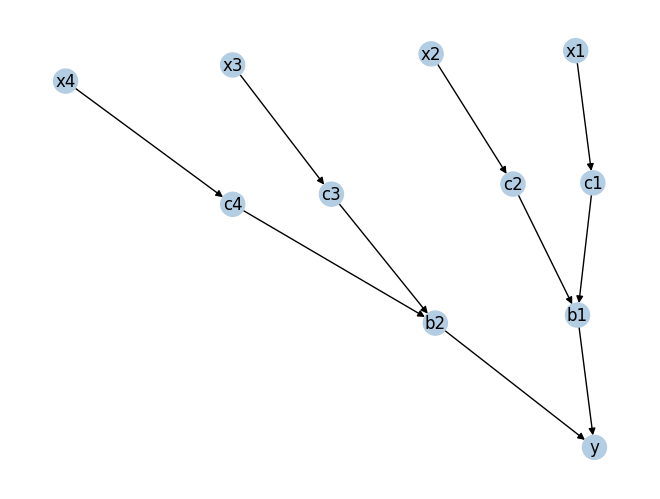

                        Node Information                         
┏━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Node ┃ Function     ┃ Sampler       ┃ Validator       ┃ Value ┃
┡━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ x1   │ -            │ float_sampler │ float_validator │ -     │
│ x2   │ -            │ float_sampler │ float_validator │ -     │
│ x3   │ -            │ float_sampler │ float_validator │ -     │
│ x4   │ -            │ float_sampler │ float_validator │ -     │
│ c1   │ copy_func    │ float_sampler │ float_validator │ -     │
│ c2   │ copy_func    │ float_sampler │ float_validator │ -     │
│ c3   │ copy_func    │ float_sampler │ float_validator │ -     │
│ c4   │ copy_func    │ float_sampler │ float_validator │ -     │
│ b1   │ compare_func │ bool_sampler  │ bool_validator  │ -     │
│ b2   │ compare_func │ bool_sampler  │ bool_validator  │ -     │
│ y    │ compare_func │ bool_sampler  │ bool_validator  │ -     │
└──────┴──────────────┴───────────────┴─────────────────┴───────┘

In [19]:
def float_validator(value):
    return -0.5 <= value <= 0.5

def float_sampler():
    return random.uniform(-0.5, 0.5)

def bool_validator(value):
    return value in {True, False}

def bool_sampler():
    return random.choice([True, False])

def copy_func(x):
    return x

def compare_func(value1, value2):
    return value1 == value2

dag = DeterministicDAG()

# Define the nodes
dag.add_node('x1', validator=float_validator, sampler=float_sampler)
dag.add_node('x2', validator=float_validator, sampler=float_sampler)
dag.add_node('x3', validator=float_validator, sampler=float_sampler)
dag.add_node('x4', validator=float_validator, sampler=float_sampler)
dag.add_node('c1', func=copy_func, validator=float_validator, sampler=float_sampler)
dag.add_node('c2', func=copy_func, validator=float_validator, sampler=float_sampler)
dag.add_node('c3', func=copy_func, validator=float_validator, sampler=float_sampler)
dag.add_node('c4', func=copy_func, validator=float_validator, sampler=float_sampler)
dag.add_node('b1', func=compare_func, validator=bool_validator, sampler=bool_sampler)
dag.add_node('b2', func=compare_func, validator=bool_validator, sampler=bool_sampler)
dag.add_node('y', func=compare_func, validator=bool_validator, sampler=bool_sampler)

# Define the edges
edges = [('x1', 'c1'), ('x2', 'c2'), ('x3', 'c3'), ('x4', 'c4'), 
         ('c1', 'b1'), ('c2', 'b1'), ('c3', 'b2'), ('c4', 'b2'), 
         ('b1', 'y'), ('b2', 'y')]
for edge in edges:
    dag.add_edge(*edge)

dag.visualize()

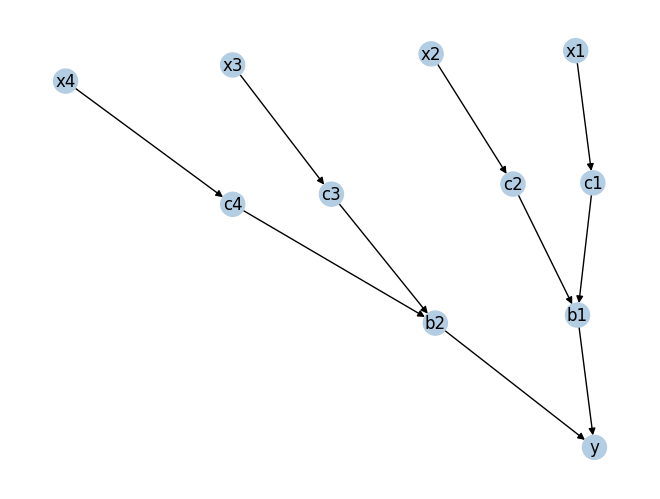

                        Node Information                         
┏━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Node ┃ Function     ┃ Sampler       ┃ Validator       ┃ Value ┃
┡━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ x1   │ -            │ float_sampler │ float_validator │ 0.1   │
│ x2   │ -            │ float_sampler │ float_validator │ 0.2   │
│ x3   │ -            │ float_sampler │ float_validator │ 0.3   │
│ x4   │ -            │ float_sampler │ float_validator │ 0.4   │
│ c1   │ copy_func    │ float_sampler │ float_validator │ 0.1   │
│ c2   │ copy_func    │ float_sampler │ float_validator │ 0.2   │
│ c3   │ copy_func    │ float_sampler │ float_validator │ 0.3   │
│ c4   │ copy_func    │ float_sampler │ float_validator │ 0.4   │
│ b1   │ compare_func │ bool_sampler  │ bool_validator  │ False │
│ b2   │ compare_func │ bool_sampler  │ bool_validator  │ False │
│ y    │ compare_func │ bool_sampler  │ bool_validator  │ True  │
└──────┴──────────────┴───────────────┴─────────────────┴───────┘

In [20]:
dag.run(dict(x1=0.1, x2=0.2, x3=0.3, x4=0.4))
dag.visualize()

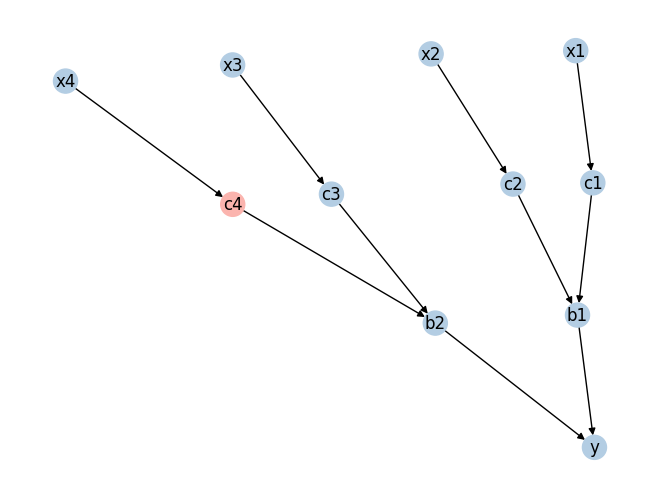

                        Node Information                         
┏━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Node ┃ Function     ┃ Sampler       ┃ Validator       ┃ Value ┃
┡━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ x1   │ -            │ float_sampler │ float_validator │ 0.1   │
│ x2   │ -            │ float_sampler │ float_validator │ 0.2   │
│ x3   │ -            │ float_sampler │ float_validator │ 0.3   │
│ x4   │ -            │ float_sampler │ float_validator │ 0.4   │
│ c1   │ copy_func    │ float_sampler │ float_validator │ 0.1   │
│ c2   │ copy_func    │ float_sampler │ float_validator │ 0.2   │
│ c3   │ copy_func    │ float_sampler │ float_validator │ 0.3   │
│ c4   │ copy_func    │ float_sampler │ float_validator │ 0.3   │
│ b1   │ compare_func │ bool_sampler  │ bool_validator  │ False │
│ b2   │ compare_func │ bool_sampler  │ bool_validator  │ True  │
│ y    │ compare_func │ bool_sampler  │ bool_validator  │ False │
└──────┴──────────────┴───────────────┴─────────────────┴───────┘

In [14]:
dag.intervene_and_run("c4", 0.3, dict(x1=0.1, x2=0.2, x3=0.3, x4=0.4))
dag.visualize()

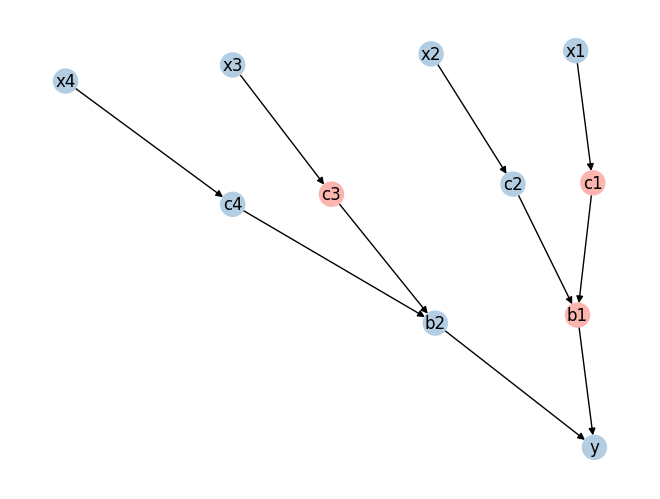

                        Node Information                         
┏━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Node ┃ Function     ┃ Sampler       ┃ Validator       ┃ Value ┃
┡━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ x1   │ -            │ float_sampler │ float_validator │ -     │
│ x2   │ -            │ float_sampler │ float_validator │ -     │
│ x3   │ -            │ float_sampler │ float_validator │ -     │
│ x4   │ -            │ float_sampler │ float_validator │ -     │
│ c1   │ copy_func    │ float_sampler │ float_validator │ 0.1   │
│ c2   │ copy_func    │ float_sampler │ float_validator │ -     │
│ c3   │ copy_func    │ float_sampler │ float_validator │ 0.3   │
│ c4   │ copy_func    │ float_sampler │ float_validator │ -     │
│ b1   │ compare_func │ bool_sampler  │ bool_validator  │ True  │
│ b2   │ compare_func │ bool_sampler  │ bool_validator  │ -     │
│ y    │ compare_func │ bool_sampler  │ bool_validator  │ -     │
└──────┴──────────────┴───────────────┴─────────────────┴───────┘

In [21]:
dag.do_interchange_intervention(
    [["b1", "c1"], ["c3"]],
    [dict(x1=0.1, x2=0.1, x3=0.1, x4=0.1),
     dict(x1=0.5, x2=0.4, x3=0.3, x4=0.2)],
)
dag.visualize()

In [22]:
def input_alignment(x: torch.tensor):
    return dict(x1=x[0], x2=x[1], x3=x[2], x4=x[3])


def output_alignment(y: torch.tensor):
    return dict(y=torch.argmax(y).item())


variable_alignment = VariableAlignment(
    dag=dag,
    hooked_model=model,
    dag_nodes=["c1", "c2", "c3", "c4", "b1", "b2"],
    input_alignment=input_alignment,
    output_alignment=output_alignment,
    intervene_model_hooks=["hook_pre1", "hook_pre2", "hook_pre3", "hook_post"],
    subspaces_sizes=[1, 1, 1, 1, 1, 1],
)

Running model to determine activation space size...


In [23]:
variable_alignment.space_size

38

In [24]:
II_dataset = dag.create_interchange_intervention_dataset(num_samples=10, max_source_inputs=6)

In [25]:
II_dataset[0]

{'base': {'x1': -0.11261944533607082,
  'x2': -0.30114950359814663,
  'x3': -0.35798442290590593,
  'x4': 0.19095410613076702},
 'source': {'c1': {'x1': -0.21796491535321694,
   'x2': 0.1758415711063409,
   'x3': -0.4706581608076631,
   'x4': -0.2659260363123589},
  'b2': {'x1': 0.3910308867064991,
   'x2': 0.3279017273302026,
   'x3': -0.4121543205763565,
   'x4': -0.21050237804723848},
  'c2': {'x1': 0.3401033619282834,
   'x2': 0.07962893011534178,
   'x3': 0.1015819653980482,
   'x4': -0.2608874458817959},
  'c4': {'x1': -0.035713948653601335,
   'x2': 0.013343709106893642,
   'x3': 0.014507950139041825,
   'x4': 0.01584901071886169},
  'c3': {'x1': 0.22390495884181172,
   'x2': -0.07785035983238497,
   'x3': -0.07257618183874492,
   'x4': 0.11597912422417866}},
 'gold': True}

In [48]:
# let's go through what to do with a datapoint

base = II_dataset[0]['base']
sources = II_dataset[0]['source']
target = II_dataset[0]['gold']

print("base:", base)
print("sources:", sources)
print("target:", target)

# now we convert the base and source input settings to the format expected by the network
def convert_input_DAG2Net(input_dict):
    return torch.tensor([input_dict['x1'], input_dict['x2'], input_dict['x3'], input_dict['x4']])

base_net = convert_input_DAG2Net(base).to(device)
sources_net = {k: convert_input_DAG2Net(v).to(device) for k, v in sources.items()}

print("base_net:", base_net)
print("sources_net:", sources_net)
model = model.to(device)

# now we can run the model on the base and source inputs, but we need the hooks
# turn off gradient tracking

acts_we_care_about = 'hook_mid2'

with torch.no_grad():
    base_acts = model.run_with_cache(base_net.unsqueeze(0))[1][acts_we_care_about]

    source_acts = {}
    for k, v in sources_net.items():
        source_acts[k] = model.run_with_cache(v.unsqueeze(0))[1][acts_we_care_about]


rotation = OrthogonalMatrix(n=base_acts.shape[1]).to(device)

# now we can rotate the base and source activations
base_acts_rotated = rotation(base_acts)

source_acts_rotated = {}
for k, v in source_acts.items():
    source_acts_rotated[k] = rotation(v)

# now we project!






base: {'x1': -0.11261944533607082, 'x2': -0.30114950359814663, 'x3': -0.35798442290590593, 'x4': 0.19095410613076702}
sources: {'c1': {'x1': -0.21796491535321694, 'x2': 0.1758415711063409, 'x3': -0.4706581608076631, 'x4': -0.2659260363123589}, 'b2': {'x1': 0.3910308867064991, 'x2': 0.3279017273302026, 'x3': -0.4121543205763565, 'x4': -0.21050237804723848}, 'c2': {'x1': 0.3401033619282834, 'x2': 0.07962893011534178, 'x3': 0.1015819653980482, 'x4': -0.2608874458817959}, 'c4': {'x1': -0.035713948653601335, 'x2': 0.013343709106893642, 'x3': 0.014507950139041825, 'x4': 0.01584901071886169}, 'c3': {'x1': 0.22390495884181172, 'x2': -0.07785035983238497, 'x3': -0.07257618183874492, 'x4': 0.11597912422417866}}
target: True
base_net: tensor([-0.1126, -0.3011, -0.3580,  0.1910], device='cuda:0')
sources_net: {'c1': tensor([-0.2180,  0.1758, -0.4707, -0.2659], device='cuda:0'), 'b2': tensor([ 0.3910,  0.3279, -0.4122, -0.2105], device='cuda:0'), 'c2': tensor([ 0.3401,  0.0796,  0.1016, -0.2609], d

tensor([[  5.9271,   3.6261,   8.2624,  18.3719, -40.9556, -25.1157,  -7.8404,
          -0.4883, -10.3660,  -0.9577, -28.8438,  -0.9337, -10.0185, -35.2949,
         -24.4401, -10.1897]], device='cuda:0')

In [50]:
base_acts_rotated

tensor([[ 5.7273e+00,  3.3473e+00,  7.2924e+00,  1.8587e+01, -3.9838e+01,
         -2.5506e+01, -9.1349e+00, -2.2460e-01, -1.0286e+01,  2.7355e-02,
         -2.9298e+01, -1.0574e+00, -9.7727e+00, -3.6296e+01, -2.4029e+01,
         -9.6429e+00]], device='cuda:0', grad_fn=<MmBackward0>)